we shall examine a small gene expression dataset, attempting to classify leukemia patients into one of two classes namely Acute Myeloid Leukemia (AML) and Acute Lymphoblastic Leukemia (ALL).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [2]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [3]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('actual.csv')
print(y.shape)
y.head()

(72, 2)


patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL

In [4]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [5]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [6]:
# Import training data
df_train = pd.read_csv('data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [7]:
#df_train.head()

In [8]:
#df_test.head()

In [9]:
# Transform all the call values to numbers (not used in this version)
df_train.replace(['A','M','P'],['1','2','3'], inplace=True)
df_test.replace(['A','M','P'],['1','2','3'], inplace=True)

In [10]:
#df_train.head()

In [11]:
#df_test.head()

In [12]:
df_train['Gene Description'] = df_train['Gene Description'].astype('category')
df_test['Gene Description'] = df_test['Gene Description'].astype('category')

df_train['Gene Description'] = df_train['Gene Description'].cat.codes
df_test['Gene Description'] = df_test['Gene Description'].cat.codes

df_train['Gene Accession Number'] = df_train['Gene Accession Number'].astype('category')
df_test['Gene Accession Number'] = df_test['Gene Accession Number'].astype('category')

df_train['Gene Accession Number'] = df_train['Gene Accession Number'].cat.codes
df_test['Gene Accession Number'] = df_test['Gene Accession Number'].cat.codes

In [13]:
train_to_keep = [col for col in df_train.columns if "call" not in col]
train_call_keep = [col for col in df_train.columns if "call" in col]

test_to_keep = [col for col in df_test.columns if "call" not in col]
test_call_keep = [col for col in df_test.columns if "call" in col]


In [14]:
X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [15]:
train_call_keep.insert(0, 'Gene Accession Number')
test_call_keep.insert(0, 'Gene Accession Number')

train_call_keep.insert(0, 'Gene Description')
test_call_keep.insert(0, 'Gene Description')

print(train_call_keep)
print(test_call_keep)

['Gene Description', 'Gene Accession Number', 'call', 'call.1', 'call.2', 'call.3', 'call.4', 'call.5', 'call.6', 'call.7', 'call.8', 'call.9', 'call.10', 'call.11', 'call.12', 'call.13', 'call.14', 'call.15', 'call.16', 'call.17', 'call.18', 'call.19', 'call.20', 'call.21', 'call.22', 'call.23', 'call.24', 'call.25', 'call.26', 'call.27', 'call.28', 'call.29', 'call.30', 'call.31', 'call.32', 'call.33', 'call.34', 'call.35', 'call.36', 'call.37']
['Gene Description', 'Gene Accession Number', 'call', 'call.1', 'call.2', 'call.3', 'call.4', 'call.5', 'call.6', 'call.7', 'call.8', 'call.9', 'call.10', 'call.11', 'call.12', 'call.13', 'call.14', 'call.15', 'call.16', 'call.17', 'call.18', 'call.19', 'call.20', 'call.21', 'call.22', 'call.23', 'call.24', 'call.25', 'call.26', 'call.27', 'call.28', 'call.29', 'call.30', 'call.31', 'call.32', 'call.33']


In [16]:
#train_to_keep.remove('Gene Description')
#test_to_keep.remove('Gene Description')

print(train_to_keep)
print(test_to_keep)

['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35', '36', '37', '38', '28', '29', '30', '31', '32', '33']
['Gene Description', 'Gene Accession Number', '39', '40', '42', '47', '48', '49', '41', '43', '44', '45', '46', '70', '71', '72', '68', '69', '67', '55', '56', '59', '52', '53', '51', '50', '54', '57', '58', '60', '61', '65', '66', '63', '64', '62']


In [17]:
X_train_call = df_train[train_call_keep].astype('int')
X_train_call['Gene Description'] = 1
X_train_call['Gene Accession Number'] = 1
X_test_call = df_test[test_call_keep].astype('int')
X_test_call['Gene Description'] = 1
X_test_call['Gene Accession Number'] = 1

X_train_tr = df_train[train_to_keep].astype('int')
X_test_tr = df_test[test_to_keep].astype('int')

In [18]:
X_train_tr.head()

Gene Description  Gene Accession Number    1    2  ...   30   31   32   33
0               219                    118 -214 -139  ... -318  -32 -124 -135
1               221                    120 -153  -73  ... -192  -49  -79 -186
2               217                    116  -58   -1  ...  -95   49  -37  -70
3               225                    124   88  283  ...  312  230  330  337
4               223                    122 -295 -264  ... -139 -367 -188 -407

[5 rows x 40 columns]

In [19]:
X_train_call.columns = train_to_keep
X_train_call.head()

Gene Description  Gene Accession Number  1  2  3  4  ...  28  29  30  31  32  33
0                 1                      1  1  1  1  1  ...   1   1   1   1   1   1
1                 1                      1  1  1  1  1  ...   1   1   1   1   1   1
2                 1                      1  1  1  1  1  ...   1   1   1   1   1   1
3                 1                      1  1  1  1  1  ...   1   1   1   3   1   1
4                 1                      1  1  1  1  1  ...   1   1   1   1   1   1

[5 rows x 40 columns]

In [20]:
X_train_tr = X_train_tr.div(X_train_call)
X_train_tr.head()

Gene Description  Gene Accession Number      1  ...          31     32     33
0             219.0                  118.0 -214.0  ...  -32.000000 -124.0 -135.0
1             221.0                  120.0 -153.0  ...  -49.000000  -79.0 -186.0
2             217.0                  116.0  -58.0  ...   49.000000  -37.0  -70.0
3             225.0                  124.0   88.0  ...   76.666667  330.0  337.0
4             223.0                  122.0 -295.0  ... -367.000000 -188.0 -407.0

[5 rows x 40 columns]

In [21]:
X_test_tr.head()

Gene Description  Gene Accession Number   39   40  ...   66   63   64   62
0               219                    118 -342  -87  ...  -58 -161  -48 -176
1               221                    120 -200 -248  ... -217 -215 -531 -284
2               217                    116   41  262  ...   63  -46 -124  -81
3               225                    124  328  295  ...   95  146  431    9
4               223                    122 -224 -226  ... -191 -172 -496 -294

[5 rows x 36 columns]

In [22]:
X_test_call.columns = test_to_keep
X_test_call.head()

Gene Description  Gene Accession Number  39  40  42  ...  65  66  63  64  62
0                 1                      1   1   1   1  ...   1   1   1   1   1
1                 1                      1   1   1   1  ...   1   1   1   1   1
2                 1                      1   1   1   1  ...   1   1   1   1   1
3                 1                      1   1   1   1  ...   1   1   1   1   1
4                 1                      1   1   1   1  ...   1   1   1   1   1

[5 rows x 36 columns]

In [23]:
X_test_tr = X_test_tr.div(X_test_call)
X_test_tr.head()

Gene Description  Gene Accession Number     39  ...     63     64     62
0             219.0                  118.0 -342.0  ... -161.0  -48.0 -176.0
1             221.0                  120.0 -200.0  ... -215.0 -531.0 -284.0
2             217.0                  116.0   41.0  ...  -46.0 -124.0  -81.0
3             225.0                  124.0  328.0  ...  146.0  431.0    9.0
4             223.0                  122.0 -224.0  ... -172.0 -496.0 -294.0

[5 rows x 36 columns]

Neither the training and testing column names are not in numeric order, so it's important that we reorder these at some point, so that the labels will line up with the corresponding data.

In [24]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [25]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.

In [26]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

(40, 7129)


0      1      2     ...    7126    7127    7128
Gene Description       219.0  221.0  217.0  ...  5352.0  2359.0  2803.0
Gene Accession Number  118.0  120.0  116.0  ...  2233.0  3077.0  7086.0
1                     -214.0 -153.0  -58.0  ...    36.0   191.0   -37.0
2                     -139.0  -73.0   -1.0  ...    11.0    76.0   -14.0
3                      -76.0  -49.0 -307.0  ...    41.0   228.0   -41.0

[5 rows x 7129 columns]

This is still messy as the first two rows are more or less duplicates of one another and we haven't yet created the column names. Let's simply turn the second row into the column names and delete the first row.

In [27]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number  118.0   120.0   116.0   ...  2233.0  3077.0  7086.0
1                      -214.0  -153.0   -58.0  ...    36.0   191.0   -37.0
2                      -139.0   -73.0    -1.0  ...    11.0    76.0   -14.0
3                       -76.0   -49.0  -307.0  ...    41.0   228.0   -41.0
4                      -135.0  -114.0   265.0  ...   -50.0   126.0   -91.0
5                      -106.0  -125.0   -76.0  ...    14.0    56.0   -25.0

[5 rows x 7129 columns]

In [28]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

Let's now take a look at some summary statistics:

In [29]:
X_train.describe()

Gene Accession Number      118.0       120.0   ...       3077.0     7086.0
count                   38.000000   38.000000  ...    38.000000  38.000000
mean                  -120.868421 -150.526316  ...   246.162281 -29.210526
std                    109.555656   75.734507  ...   229.909544  30.851132
min                   -476.000000 -327.000000  ...    -2.000000 -94.000000
25%                   -138.750000 -205.000000  ...   121.875000 -42.750000
50%                   -106.500000 -141.500000  ...   186.333333 -26.000000
75%                    -68.250000  -94.750000  ...   262.583333 -11.500000
max                     17.000000  -20.000000  ...  1064.333333  36.000000

[8 rows x 7129 columns]

Clearly there is some variation in the scales across the different features. Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [30]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

With 7129 features, it's also worth considering whether we might be able to reduce the dimensionality of the dataset. Once very common approach to this is principal components analysis (PCA). Let's start by leaving the number of desired components as an open question:

In [31]:
pca = PCA()
pca.fit_transform(X_train)

array([[-1.13781121e+03, -1.76158648e+03,  1.05530316e+03, ...,
        -1.67534464e+03, -4.92010225e+02,  8.73320949e-12],
       [-1.71405737e+03,  6.45855110e+03,  6.79593822e+03, ...,
         2.16542255e+02, -6.25044914e+01,  8.73320949e-12],
       [-1.14909441e+04, -1.00633418e+04,  1.81621964e+04, ...,
        -1.13590533e+03,  6.61630537e+02,  8.73320949e-12],
       ...,
       [-2.41643276e+04,  1.06074122e+04, -8.14911388e+03, ...,
        -4.05599681e+02,  8.49155212e+02,  8.73320949e-12],
       [-1.75893435e+04,  1.01745988e+04, -1.10641345e+04, ...,
         5.37612562e+02, -1.20387042e+03,  8.73320949e-12],
       [-8.82330223e+03,  2.04686411e+03, -6.43729205e+03, ...,
         4.59349034e+02,  1.20761755e+03,  8.73320949e-12]])

Let's set a threshold for explained variance of 90% and see how many features are required to meet that threshold

25 features explain around 90% of the variance. From 7129 features to 25, not too bad.


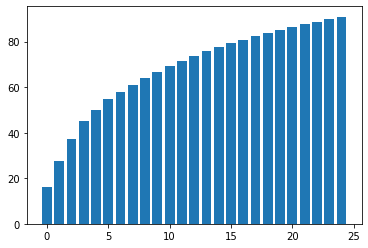

In [32]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

We can't plot something in 22 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments.

[]

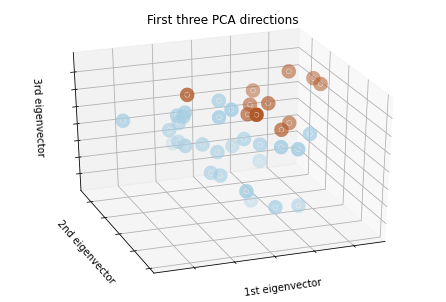

In [33]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

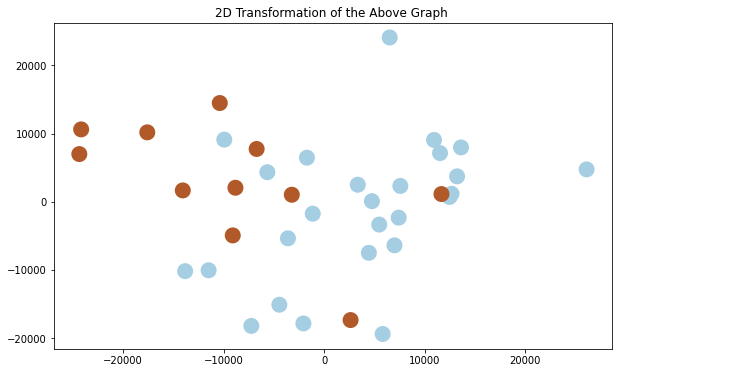

In [34]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

**Model Building**

Baseline - Establish a naive baseline . 

This doesn't require a model, we are just taking the proportion of tests that belong to the majority class as a baseline. In other words, let's see what happens if we were to predict that every patient belongs to the "ALL" class.

In [35]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


K-Means Clustering

First we shall try an unsupervised clustering approach using the scaled data.

K-means accuracy: 0.265


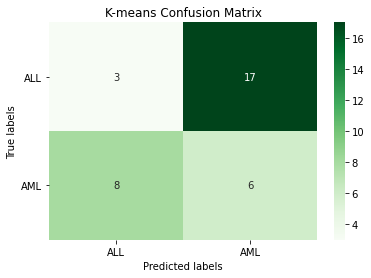

In [36]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Naive Bayes

First Supervised Approach

Naive Bayes accuracy: 0.794


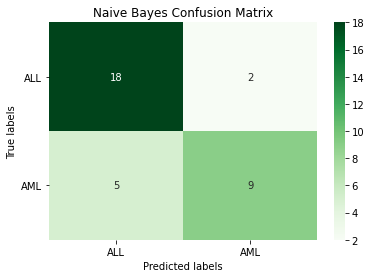

In [37]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Logistic Regression

Another very standard approach is logistic regression. Here we will be using grid search cross-validation tuning to try and determine the best hyperparameters. We don't need to scale the data for logistic regression, nor are we using the PCA version of the dataset.

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


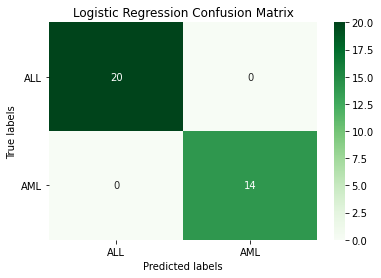

In [38]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Support Vector Machine

Here we will try another traditional approach, a support vector machine (SVM) classifier. For the SVM, so we using the PCA version of the dataset. Again we use grid search cross-validation to tune the model.

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 1.0


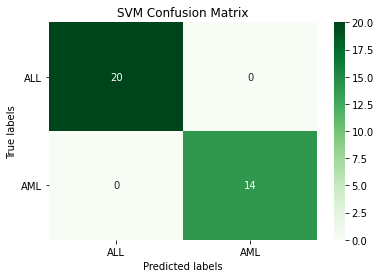

In [39]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Random Forest

 We don't need scaled data for this, so again we wont use the scaled version of the dataset, just a grid search for tuning the hyperparameters.

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


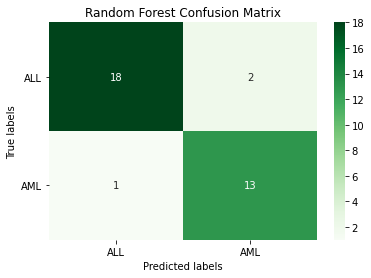

In [40]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

XG Boost

XGB — PCA with Grid Search

Best Parameters:
 {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 40}
XGB (PCA with Grid Search) accuracy: 0.647


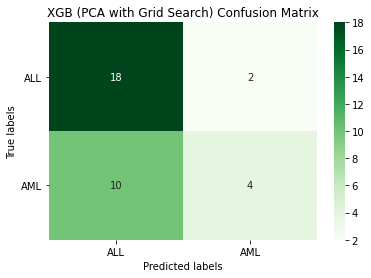

In [41]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

fixed_params = {'random_state': 0,
                'n_jobs': -1}

xgb_model = GridSearchCV(xgb.XGBClassifier(**fixed_params), 
                       param_grid = xgb_grid_params, 
                       scoring = 'accuracy',
                       cv = 3)

xgb_model.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", xgb_model.best_params_)

# Get the best model
xgb_model_best = xgb_model.best_estimator_

# Make predictions using the optimised parameters
xgb_pred = xgb_model_best.predict(X_test_pca)

print('XGB (PCA with Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb_pred), 3))

cm_xgb = confusion_matrix(y_test.iloc[:,1], xgb_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA with Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

XGB — PCA with no Grid Search

Accuracy:  0.765


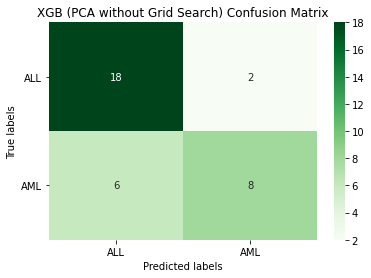

In [42]:
xgb2_model = xgb.XGBClassifier()
xgb2_model.fit(X_train_pca, y_train.iloc[:,1])

xgb2_pred = xgb2_model.predict(X_test_pca)

print('Accuracy: ', round(accuracy_score(y_test.iloc[:,1], xgb2_pred), 3))

cm_xgb2 = confusion_matrix(y_test.iloc[:,1], xgb2_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb2, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA without Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

XGB — no PCA or Grid Search

XGB (no PCA or Grid Search) accuracy: 0.912


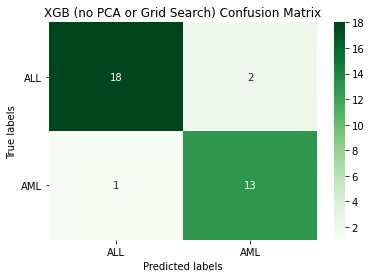

In [43]:
xgb3_model = xgb.XGBClassifier()
xgb3_model.fit(X_train, y_train.iloc[:,1])

xgb3_pred = xgb3_model.predict(X_test)

print('XGB (no PCA or Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb3_pred), 3))

cm_xgb3 = confusion_matrix(y_test.iloc[:,1], xgb3_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb3, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (no PCA or Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Neural Network

A "shallow" learning model with one hidden layer — adding several extra layers with so few training datapoints would just lead to overfitting.

In [44]:
# Create model architecture
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7129,)))
model.add(Dense(1, activation='sigmoid'))

In [45]:
# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [46]:
# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

In [47]:
# Set up early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(partial_X_train,
            partial_y_train,
            epochs=50,
            batch_size=4,
            validation_data=(X_val, y_val),
            callbacks=[es])

Epoch 1/50
8/8 [==============================] - 1s 75ms/step - loss: 1.1685 - accuracy: 0.4250 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 3.6394e-04 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 00004: early stopping


Neural Network accuracy:  0.882


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


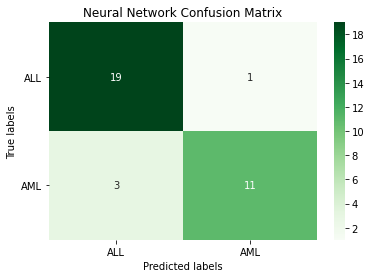

In [48]:
# Make predictions
nn_pred = model.predict_classes(X_test_scl)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 3))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);